# VECTORIZED HDC METHOD

In [1]:
# Import Basic Packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import string
import time
import random
import copy
import re
import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from nltk import sent_tokenize,word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
from tabulate import tabulate
from tqdm.notebook import tqdm_notebook
from numpy import loadtxt
from os import listdir

## Data Insights and Pre-Processing

In [2]:
### Function: Collects sample data from files in Stanford Dataset Subfolders
    ## Inputs: folderpath: Path to Desired Folder
    ##         sentiment:  Sentiment Value (0 or 1)
    ## Output: df: Pandas Dataframe of all Sample Data found in desired folder
def stanfordDatasetFolderDataLoader(folderpath, sentiment):
    file_list=listdir(folderpath)

    df = pd.DataFrame(columns = ['Review', 'Sentiment'])
    for file in file_list:
        filepath=folderpath + file
        f = open(filepath,'r', encoding="utf-8")
        sample = f.read()
        f.close()
        df = df.append({'Review' : sample, 'Sentiment' : sentiment}, ignore_index = True)
    return df

# Choose Dataset (0: Sentiment140, 1: Stanford IMBD Dataset)
dataset = 1

# Load Dataset
if (dataset==0):
    print('Using Sentiment140 Twitter Dataset...')
    # Read in Sentiment140 data from CSV
    df = pd.read_csv('./Sentiment140_Tweets/data.csv')
    df.columns =['Sentiment', 'IDs', 'Date', 'Flag', 'User', 'Tweet']
else:
    print('Using Stanford IMBD Movie Review Dataset...')
    # Read in Training Stanford IMBD Movie Review data from subfolders
    train_pos=stanfordDatasetFolderDataLoader('./StanfordMovie/train/pos/',1)
    train_neg=stanfordDatasetFolderDataLoader('./StanfordMovie/train/neg/',0)
    train_df=pd.concat([train_pos, train_neg], axis=0)
    
    # Read in Testing Stanford IMBD Movie Review data from subfolders
    test_pos=stanfordDatasetFolderDataLoader('./StanfordMovie/test/pos/',1)
    test_neg=stanfordDatasetFolderDataLoader('./StanfordMovie/test/neg/',0)
    test_df=pd.concat([test_pos, test_neg], axis=0)

    df=pd.concat([train_df, test_df], axis=0)
print('Total number of Samples In Dataset:', len(df))

Using Stanford IMBD Movie Review Dataset...
Total number of Samples In Dataset: 50000


In [3]:
# Dataset Cleanup:

# Sentiment140 Sentiment Clean Up
if dataset==0:
    # Replace Sentiment of 4 (Positive) with 1
    df["Sentiment"].replace({4: 1}, inplace=True)
    # Eliminate Neutral Tweets, if any
    df = df[df['Sentiment'] != 2]

# Check for Null Values
if ( not df.isnull().values.any() ):
    print("Dataset in Use has No NULL values.")
else:
    df.dropna(inplace=True)

print("Dataset Length after Cleanup:", len(df))

Dataset in Use has No NULL values.
Dataset Length after Cleanup: 50000


In [4]:
# Downsample the Dataset to 5000 Total Samples
percentage=5000/len(df)
df_downsampled = df.sample(frac=percentage,random_state=0)
df_downsampled

,Review,Sentiment
11841,"Often tagged as a comedy, The Man In The White...",1
7102,After Chaplin made one of his best films: Doug...,0
8019,I think the movie was one sided I watched it r...,0
747,I have fond memories of watching this visually...,1
5142,This episode had potential. The basic premise ...,0
...,...,...
9869,Reading the various external reviews of Roger ...,1
4692,To soccer fans every where -- stay away from t...,0
12143,This is such a great movie to watch with young...,1
9963,have just got back from seeing this brilliantl...,1


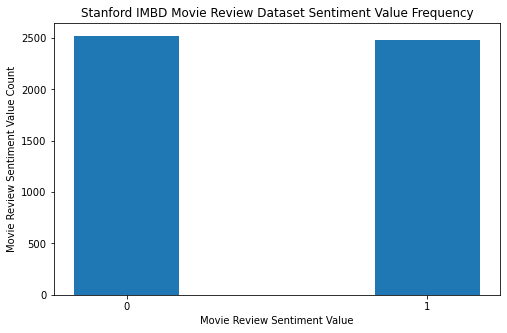

Where Sentiment is Positive when Sentiment Value = 1 and Negative when Sentiment Value = 0


In [5]:
# Visualization of Dataset Sentiment Outcomes - Ensured Even Distribution of Outcomes
sent_count = df_downsampled['Sentiment'].value_counts()
plt.figure(figsize=(8, 5))
w = 0.35  
plt.bar(x=np.arange(len(sent_count)), height=sent_count, width = w)
plt.xticks(np.arange(len(sent_count)), sent_count.index.tolist())

if dataset==0:
    plt.xlabel('Tweet Sentiment Value')
    plt.ylabel('Tweet Sentiment Value Count')
    plt.title('Sentiment140 Twitter Dataset Sentiment Value Frequency')
else:
    plt.xlabel('Movie Review Sentiment Value')
    plt.ylabel('Movie Review Sentiment Value Count')
    plt.title('Stanford IMBD Movie Review Dataset Sentiment Value Frequency')
plt.show()
print('Where Sentiment is Positive when Sentiment Value = 1 and Negative when Sentiment Value = 0')

In [6]:
### Function: Pre-Processes Samples
    ## Inputs: samples:        Array of samples
    ##         sample_results: Sentiment of Input Samples
    ## Outputs: pre_procc_samps: Array of samples pre-processed
    ##          pre_procc_res:   Array of results for pre-processed samples      
def PreProcess(samples, sample_results):
    pre_procc_samps = []
    pre_procc_res=[]

    # Get Negation Words From Text File
    negation_word_list = loadtxt("negation_words.txt", delimiter="\n", dtype="str")
    # Storing all punctuations using RE library like !;,"% etc
    re_puncs = re.compile('[%s]' % re.escape(string.punctuation))
    # Storing all stop words like a, an, the, when, there, this etc
    stop_word  = set(stopwords.words('english'))
    # Lemmatizing object
    lem = WordNetLemmatizer()
    # Using Porter Stemmer
    p_stem = PorterStemmer()

    index=0
    for sample in samples:
        
        # Replace Repeated Characters with 2 instance and get rid or URLs / Handles
        sample = re.sub(r"(\w)\1{2,}", r"\1\1", str(sample))
        sample = re.sub(r"http\S+", "", str(sample))
        sample = re.sub(r"@\S+", "", str(sample))

        # Get words in sample
        words = word_tokenize(str(sample))

        # Converting all characters to lower case
        words_lower = [w.lower() for w in words]              

        # Remove all punctuation
        words_lower_no_punc = [re_puncs.sub('', w) for w in words_lower]

        # Keep only alpha words
        words_lower_alpha = [i for i in words_lower_no_punc if i.isalpha()]

        # Negation Handling
        handled_words=[]
        negation_word=""
        for word in words_lower_alpha:
            if word in negation_word_list:
                negation_word = word
            elif negation_word != "":
                word=negation_word+"_"+word
                negation_word=""
                handled_words.append(word)
            else:
                handled_words.append(word)

        # Removing all stop words
        words_lower_alpha_nostop = [w for w in handled_words if w not in stop_word]

        # Doing Lemmatizing of words
        words_lower_alpha_nostop_lemma = [lem.lemmatize(w) for w in words_lower_alpha_nostop]

        # Stemming process
        words_lower_alpha_nostop_lemma_stem = [p_stem.stem(w) for w in words_lower_alpha_nostop_lemma]

        # Convert back to string and (possibly) one-hot encode tweet
        pre_procc_str = ' '.join(words_lower_alpha_nostop_lemma_stem)
        if (pre_procc_str != ""):
            pre_procc_samps.append(pre_procc_str)
            pre_procc_res.append(sample_results[index])
        index=index+1
        
    return pre_procc_samps, pre_procc_res

# Pre-Proccess the Dataset and Get Final Train/Test Sets:
if dataset==0:
    Xdf, Ydf = PreProcess(df_downsampled['Tweet'].to_numpy(), df_downsampled['Sentiment'].to_numpy())
else:
    Xdf, Ydf = PreProcess(df_downsampled['Review'].to_numpy(), df_downsampled['Sentiment'].to_numpy())

TrainXdf,TestXdf, TrainYdf, TestYdf = train_test_split(Xdf, Ydf, test_size=.2, random_state=2)

TrainYdf=np.array(TrainYdf)
TestYdf=np.array(TestYdf)
TrainXdf[1:5]

['like standard sli flick involv top action unbeliev stunt unbeliev not_intend complimentari retard dialogu love steam pile mountain goat dung high hope base trailer thought stalon go forc hasbeen day yield smarter peopl make action film would place credibl hero credibl situat stori set believ action would prevail crave action least close enough realiti imagin fear excit would come event limit knowledg hypothermia effect render least one scene laughabl ridicul judg dredd better know go theater go see comic book made movi charact set everyth els beyond comparison anyth might encount cliffhang hand turn mountain climb guid rambo say yo adrian',
 'outing certainli nt_live predecessor share memor moment person favorit lay wast citi block videodisc cannon see close nimoy face singl tear shed left eye know point nimoy kill machin viewer ca nt_help pull emot turmoil understand previous flat affect facad absolut brillianc sex scene display nice balanc carnal not_pornograph afterward felt prett

## Pre-Training Initialization
### Item Memory Function

In [7]:
### Function: Item Memory Generation
    ## Inputs: dim: Number of columns (i.e. length of HV)
    ##         num_rows: Number of rows (i.e. number of features)
    ## Output: dictMem: Item Memory containing HVs for each supported char
def itemMemGen(dim, num_rows):
    dictMem = np.random.randint(2, size=(num_rows, dim), dtype='int32')
    # dictMem[dictMem == 0] = -1
    return dictMem

# Parameters:
HV_dim = 10000

### Training Functions

In [8]:
### Function: Encodes a Sample into a HV using VECTORIZED HDC Approach
    ## Inputs: sample:      Training Sample
    ##         itemMem:     Generate Item Memory
    ## Output: sample_HV: HV of inputted sample 
def encode(sample, itemMem):
    return np.dot(sample,itemMem)

### Function: VECTORIZED HDC Training Function that creates an Associative Memory for the Model
    ## Inputs: X:           Training Samples
    ##         Y:           Outputs of Training Samples
    ##         itemMem:     Generated Item Memory
    ##         HV_dim:      Dimension of HV
    ##         sent_count:  Number of Possible Sentiment Values
    ## Output: assocMem: Associative Memory 
def train(X, Y, itemMem, HV_dim, sent_count):
    assocMem = np.zeros((sent_count, HV_dim), dtype='int32')
    sample_idx = 0
    
    for sample in X:
        sample_HV = encode(sample.reshape(1,-1), itemMem)
        assocMem[Y[sample_idx]] = np.add(assocMem[Y[sample_idx]], sample_HV)
        sample_idx += 1
    return assocMem

### Testing Functions

In [9]:
### Function: Compares Input HV to Class HVs and Returns the Predicted Class
    ## Inputs: assocMem: Model's Associative Memory
    ##         inputHV:  Encoded HV of a sample
    ## Output: pred: the predicted class
def get_prediction(assocMem, inputHV):
    pred = assocMem[0]
    maximum = np.NINF

    for index in range(len(assocMem)):
        similarity = cosine_similarity([inputHV, assocMem[index]])[0][1]  
        if (similarity > maximum):
            pred = index
            maximum = similarity

    return pred

### Function: Tests the VECTORIZED HDC Model and Returns Accuracy of Model
    ## Inputs: itemMem:     Generated Item Memory
    ##         assocMem:    Model's Associative Memory
    ##         TestXdf:     Test Samples
    ##         TextYdf:     Sentiment of Test Samples
    ## Output: accuracy: Accuracy of the Model
def test(itemMem, assocMem, TestXdf, TestYdf):
    true_pos_count=0
    false_pos_count=0
    correct_count = 0

    for index in range(len(TestXdf)):
        prediction = get_prediction(assocMem, encode(TestXdf[index], itemMem))
        if (TestYdf[index] == prediction):
            correct_count += 1
            if prediction==1:
                true_pos_count += 1
        elif prediction==1:
            false_pos_count += 1
            
    accuracy = (correct_count / len(TestYdf)) * 100
    if (true_pos_count+false_pos_count) != 0:
        precision = (true_pos_count/ (true_pos_count+false_pos_count)) * 100
    else:
        precision=0
    return accuracy, precision

## Optimal Hyperparameter Search
### One-Shot Training/Accuracy of Various Sets of Hyperparameter Values

In [10]:
# Hyperparameters
vector_types = [0, 1, 2] # 0 for COUNT VECTOR, 1 for BINARY COUNT VECTOR, 2 for NORMALIZED COUNT VECTOR(tf-idf)
ngram_types = [ (1,1), (2,2), (3,3), (1,2), (1,3)] # (1,1) for UNIGRAMS, (2,2) for BIGRAMS, (3,3) for TRIGRAMS, (1,2) for (UNIGRAMS,BIGRAMS), (1,3) for (UNIGRAMS,TRIGRAMS) 
if dataset == 0:
    mindf_values=[3, 5, 10]
else:
    mindf_values=[10, 35, 60]

k_greater_10k = [0.05, 0.07, 0.10]
k_greater_1k = [0.35, 0.50, 0.75]
k_lessThan_1k = [0.75, 0.85, 0.90]

# Optimal Result Initializations
best_acc=0
vector_type_best=0
mindf_best=0
ngram_type_best=0
k_best=0
numfeat_best=0

best_assocMem=[]
itemMem_best=[]
Train_best=[]
Test_best=[]

# Generate Table Initialization
table_data=[]
col_names = ["VECTOR TYPE", "NGRAM", "MINIMUM DOCUMENT FREQUENCY", "K PERCENT", "FINAL NUMBER OF FEATURES", "ONE-SHOT ACCURACY", "ONE-SHOT-PRECISION", "TRAINING TIME (s)", "NUMBER OF TRAINING SAMPLES", "TESTING TIME (s)", "NUMBER OF TESTING SAMPLES"]

for vector_type in tqdm_notebook(vector_types):
    for ngram in tqdm_notebook(ngram_types):
        for mindf in mindf_values:
            
            # Build Vectorizer With Desired Hyperparameters
            if (vector_type==0):
                cnt = CountVectorizer(analyzer="word", ngram_range=ngram, min_df=mindf)
            elif(vector_type==1):
                cnt = CountVectorizer(analyzer="word", ngram_range=ngram, min_df=mindf, binary=True)
            elif (vector_type==2):
                cnt = TfidfVectorizer(analyzer="word", ngram_range=ngram, min_df=mindf)

            try:
                # Fit Vectorizer and Transform Training/Testing Sets
                TrainXdf_temp = cnt.fit_transform(TrainXdf).toarray()
                TestXdf_temp = cnt.transform(TestXdf).toarray()

            except (ValueError):  
                if (vector_type==0):
                    cnt = CountVectorizer(analyzer="word", ngram_range=ngram)
                    mindf="-"
                elif(vector_type==1):
                    cnt = CountVectorizer(analyzer="word", ngram_range=ngram, binary=True)
                    mindf="-"
                elif (vector_type==2):
                    cnt = TfidfVectorizer(analyzer="word", ngram_range=ngram)
                    mindf="-"
                
                # Fit Vectorizer and Transform Training/Testing Sets
                TrainXdf_temp = cnt.fit_transform(TrainXdf).toarray()
                TestXdf_temp = cnt.transform(TestXdf).toarray()

            # Get % of Current Features want SelectKBest to Keep:
            if ( TrainXdf_temp.shape[1] >= 10000 ):
                k_values=copy.copy(k_greater_10k)
            elif ( TrainXdf_temp.shape[1] >= 1000 ):
                k_values=copy.copy(k_greater_1k)
            elif ( TrainXdf_temp.shape[1] >= 100 ):
                k_values=copy.copy(k_lessThan_1k)
            else:
                continue

            for k_val in k_values:
                with warnings.catch_warnings():
                    warnings.simplefilter("error")
                    try:
                        # Feature Selection using Chi2
                        Selector=SelectKBest(chi2, k=int(k_val*TrainXdf_temp.shape[1]))
                        TrainXdf_temp1= Selector.fit_transform(TrainXdf_temp, TrainYdf)
                        TestXdf_temp1 = Selector.transform(TestXdf_temp)
                    except UserWarning:
                        TrainXdf_temp1=copy.copy(TrainXdf_temp)
                        TestXdf_temp1=copy.copy(TestXdf_temp)
                        k_val="-"

                # Generate Item Memory
                itemMem=itemMemGen(HV_dim, TrainXdf_temp1.shape[1])

                # Train Model (i.e. Generate Model's Associative Memory)
                t0=time.time()
                assocMem = train(TrainXdf_temp1, TrainYdf, itemMem, HV_dim, len(sent_count))
                t1=time.time()
                train_time = t1-t0

                # One-Shot Training Results
                t0=time.time()
                one_shot_accuracy, one_shot_precision = test(itemMem, assocMem, TestXdf_temp1, TestYdf)
                t1=time.time()
                test_time = t1-t0

                # Add Data to Table
                data = [vector_type, ngram, mindf, k_val, TrainXdf_temp1.shape[1], one_shot_accuracy, one_shot_precision, train_time, len(TrainYdf), test_time, len(TestYdf)]
                table_data.append(data)

                if one_shot_accuracy>best_acc:
                    best_acc=one_shot_accuracy
                    best_assocMem=copy.copy(assocMem)
                    itemMem_best=copy.copy(itemMem)
                    Train_best=copy.copy(TrainXdf_temp1)
                    Test_best=copy.copy(TestXdf_temp1)
                    
                    cnt_best=cnt
                    vector_type_best=vector_type
                    mindf_best=mindf
                    ngram_type_best=ngram
                    k_best=k_val
                    numfeat_best=TrainXdf_temp1.shape[1]

# Get Necessary Components for Best Model
assocMem=copy.copy(best_assocMem)
itemMem=copy.copy(itemMem_best)
TrainXdf=copy.copy(Train_best)
TestXdf=copy.copy(Test_best)

# Save Results to File
df=pd.DataFrame(table_data, columns=col_names)
filepath="./Results/HyperparameterResults/VECTORIZED_" + str(dataset) +".csv"
df.to_csv(filepath)
            
print("Results of Various Hyperparameter Sets:")
print(tabulate(table_data, headers=col_names, tablefmt="simple"))
print("\nVector Type Key: 0 for COUNT VECTOR, 1 for BINARY COUNT VECTOR, 2 for NORMALIZED COUNT VECTOR(tf-idf)")
print("NGRAM Key: 1 for UNIGRAMS, 2 for BIGRAMS, 3 for TRIGRAMS, (1,2) for (UNIGRAMS & BIGRAMS), (1,3) for (UNIGRAMS,BIGRAMS, & TRIGRAMS)\n")
print("Best Hyperparameters: VECTOR TYPE: ", vector_type_best, ", NGRAM: ", ngram_type_best, ", MINIMUM DOCUMENT FREQUENCY: ", mindf_best, ", K PERCENT: ", k_best, ", FINAL NUMBER OF FEATURES: ", numfeat_best)
print("Best One-Shot Accuracy: ", best_acc)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Results of Various Hyperparameter Sets:
  VECTOR TYPE  NGRAM      MINIMUM DOCUMENT FREQUENCY    K PERCENT    FINAL NUMBER OF FEATURES    ONE-SHOT ACCURACY    ONE-SHOT-PRECISION    TRAINING TIME (s)    NUMBER OF TRAINING SAMPLES    TESTING TIME (s)    NUMBER OF TESTING SAMPLES
-------------  -------  ----------------------------  -----------  --------------------------  -------------------  --------------------  -------------------  ----------------------------  ------------------  ---------------------------
            0  (1, 1)                             10         0.35                        1598                 64.2               62.5498            1287.8                             4000           302.545                           1000
            0  (1, 1)                             10         0.5                         2284                 64.1               62.475             1906.37                            4000           443.261                           1000
            

## Retraining Optimal Model

In [11]:
### Function: VECTORIZED HDC Re-Training Function that creates a New Associative Memory for the Model
    ## Inputs: X:           Training Samples
    ##         Y:           Outputs of Training Samples
    ##         itemMem:     Generated Item Memory
    ##         assocMem:    Associative Memory of Current Model
    ##         alpha:       Learning Rate Parameter
    ## Output: assocMem: New Associative Memory
def retrain(X, Y, itemMem, assocMem, alpha):
    sample_index = 0
    for sample in X:
        sample_HV = encode(sample, itemMem)
        prediction = get_prediction(assocMem, sample_HV)
        if prediction != Y[sample_index]:
            assocMem[Y[sample_index]] = np.add(assocMem[Y[sample_index]], alpha * sample_HV)
            assocMem[prediction] = np.subtract(assocMem[prediction], alpha * sample_HV)
        sample_index += 1
    return assocMem

# Re-Train Optimal Model with Learning Parameter
learningparam_results=[]
num_epochs = 20
print('-------- Retraining Model w Learning Parameter: ', num_epochs, ' Epochs --------')
for epoch in range(num_epochs):
    assocMem = retrain(TrainXdf, TrainYdf, itemMem, assocMem, alpha = num_epochs - epoch)
    acc, prec = test(itemMem, assocMem, TestXdf, TestYdf)
    print('Epoch ', (epoch+1), ': ', acc)
    learningparam_results.append([acc,prec])

# Re-Train Optimal Model without Learning Parameter
assocMem=copy.copy(best_assocMem)
no_learningparam_results=[]
print('-------- Retraining Model without Learning Parameter: ', num_epochs, ' Epochs --------')
for epoch in range(num_epochs):
    assocMem = retrain(TrainXdf, TrainYdf, itemMem, assocMem, alpha = 1)
    acc, prec = test(itemMem, assocMem, TestXdf, TestYdf)
    print('Epoch ', (epoch+1), ': ', acc)
    no_learningparam_results.append([acc,prec])

# Save All Results to Files
col_name=["Accuracy", "Precision"]

df_lp=pd.DataFrame(learningparam_results, columns=col_name)
filepath="./Results/EpochResults_LearningParam/VECTORIZED_" + str(dataset) + ".csv"
df_lp.to_csv(filepath)

df_nlp=pd.DataFrame(no_learningparam_results, columns=col_name)
filepath="./Results/EpochResults_NoLearningParam/VECTORIZED_" + str(dataset) + ".csv"
df_nlp.to_csv(filepath)

-------- Retraining Model w Learning Parameter:  20  Epochs --------
Epoch  1 :  82.6
Epoch  2 :  83.89999999999999
Epoch  3 :  83.1
Epoch  4 :  82.89999999999999
Epoch  5 :  83.3
Epoch  6 :  85.7
Epoch  7 :  83.7
Epoch  8 :  84.5
Epoch  9 :  83.7
Epoch  10 :  85.9
Epoch  11 :  86.1
Epoch  12 :  85.3
Epoch  13 :  84.1
Epoch  14 :  85.7
Epoch  15 :  85.5
Epoch  16 :  85.9
Epoch  17 :  85.9
Epoch  18 :  86.2
Epoch  19 :  86.1
Epoch  20 :  86.1
-------- Retraining Model without Learning Parameter:  20  Epochs --------
Epoch  1 :  86.1
Epoch  2 :  87.2
Epoch  3 :  87.3
Epoch  4 :  86.8
Epoch  5 :  86.8
Epoch  6 :  87.2
Epoch  7 :  87.0
Epoch  8 :  86.5
Epoch  9 :  86.4
Epoch  10 :  86.4
Epoch  11 :  86.4
Epoch  12 :  86.2
Epoch  13 :  86.2
Epoch  14 :  86.1
Epoch  15 :  86.6
Epoch  16 :  86.3
Epoch  17 :  86.4
Epoch  18 :  86.1
Epoch  19 :  86.2
Epoch  20 :  86.7
